## Machine Learning: Kaggle Competition Homework

Submitted by:
 - MARTINEZ, Kyle
 - FERNANDEZ, Chelsea 
 - DECULAWAN, Ryan
 - PPOSADAS, Annika
 - HAUSCHILD, Melanie


## Project Description 

Ask a home buyer to describe their dream house, and they probably won't begin with the height of the basement ceiling or the proximity to an east-west railroad. But this playground competition's dataset proves that much more influences price negotiations than the number of bedrooms or a white-picket fence.

With 79 explanatory variables describing (almost) every aspect of residential homes in Ames, Iowa, this competition challenges you to predict the final price of each home.

**Practice Skills**
- Creative feature engineering 
- Advanced regression techniques like random forest and gradient boosting


**Goal**

It is your job to predict the sales price for each house. For each Id in the test set, you must predict the value of the SalePrice variable. 


**Metric**

Submissions are evaluated on Root-Mean-Squared-Error (RMSE) between the logarithm of the predicted value and the logarithm of the observed sales price. (Taking logs means that errors in predicting expensive houses and cheap houses will affect the result equally.)

**Submission File Format**

The file should contain a header and have the following format:

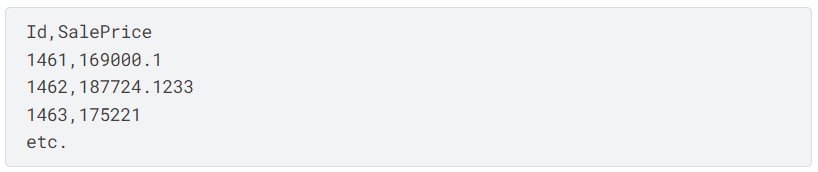

## Import Dependencies

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

## Data Preprocessing
**TODO**
- What preprocessing techniques have you used and why?

In [2]:
import os
os.chdir(r'C:\Users\RJ\Desktop\Minor in DS\DATA103\HW1\DATA103\Homework 2')

In [3]:
train_csv_path = './data/train.csv'
test_csv_path = './data/test.csv'
train_df = pd.read_csv(train_csv_path, index_col='Id')
test_df = pd.read_csv(test_csv_path, index_col='Id')

In [4]:
train_df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [5]:
test_df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,TA,Y,SBrkr,896,0,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,NaN,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140,0,0,0,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,TA,Y,SBrkr,1329,0,0,1329,0.0,0.0,1,1,3,1,Gd,6,Typ,0,NaN,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393,36,0,0,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,Gd,Y,SBrkr,928,701,0,1629,0.0,0.0,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.0,Fin,2.0,482.0,TA,TA,Y,212,34,0,0,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,6,1998,1998,Gable,CompShg,VinylSd,VinylSd,BrkFace,20.0,TA,TA,PConc,TA,TA,No,GLQ,602.0,Unf,0.0,324.0,926.0,GasA,Ex,Y,SBrkr,926,678,0,1604,0.0,0.0,2,1,3,1,Gd,7,Typ,1,Gd,Attchd,1998.0,Fin,2.0,470.0,TA,TA,Y,360,36,0,0,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,8,5,1992,1992,Gable,CompShg,HdBoard,HdBoard,None,0.0,Gd,TA,PConc,Gd,TA,No,ALQ,263.0,Unf,0.0,1017.0,1280.0,GasA,Ex,Y,SBrkr,1280,0,0,1280,0.0,0.0,2,0,2,1,Gd,5,Typ,0,NaN,Attchd,1992.0,RFn,2.0,506.0,TA,TA,Y,0,82,0,0,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1460 entries, 1 to 1460
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

In [7]:
train_df.describe()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1379.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,46.549315,567.240411,1057.429452,1162.626712,346.992466,5.844521,1515.463699,0.425342,0.057534,1.565068,0.382877,2.866438,1.046575,6.517808,0.613014,1978.506164,1.767123,472.980137,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,161.319273,441.866955,438.705324,386.587738,436.528436,48.623081,525.480383,0.518911,0.238753,0.550916,0.502885,0.815778,0.220338,1.625393,0.644666,24.689725,0.747315,213.804841,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1900.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,223.000000,795.750000,882.000000,0.000000,0.000000,1129.500000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1961.000000,1.000000,334.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,477.500000,991.500000,1087.000000,0.000000,0.000000,1464.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1980.000000,2.000000,480.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,0.000000,808.000000,1298.250000,1391.250000,728.000000,0.000000,1776.750000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2002.000000,2.000000,576.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,2336.000000,6110.000000,4692.000000,2065.000000,572.000000,5642.000000,3.000000,2.000000,3.000000,2.000000,8.000000,3.000000,14.000000,3.000000,2010.000000,4.000000,1418.000000,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


#### Handling Missing Values and Duplicate Values

In [8]:
# Check the count of duplicate rows in the dataset
train_df.duplicated().sum()

0

In [9]:
# Show a summary table for a single dataframe
def summarize_dataframe(df):
    summary = {
        'Column': [],
        'Data Type': [],
        'Null Count': [],
        'Unique Values': [],
        'Range': [],
        'Mean': [],
        'Standard Deviation': [],
    }

    for col in df.columns:
        summary['Column'].append(col)
        summary['Data Type'].append(df[col].dtype)
        summary['Null Count'].append(df[col].isnull().sum())
            
        # Show list of unique values if categorical
        if df[col].dtype.kind not in 'iufc':
            if df[col].dropna().nunique() < 20:
                # Show unique values by count (descending order)
                summary['Unique Values'].append(df[col].value_counts(dropna=True).index.tolist())
            else:
                summary['Unique Values'].append(None)
        else:
            summary['Unique Values'].append(None)

        if pd.api.types.is_numeric_dtype(df[col]):
            summary['Range'].append((df[col].min(), df[col].max()))
            summary['Mean'].append(round(df[col].mean(), 2))
            summary['Standard Deviation'].append(round(df[col].std(), 2))
        else:
            summary['Range'].append(None)
            summary['Mean'].append(None)
            summary['Standard Deviation'].append(None)

    summary_df = pd.DataFrame(summary)
    return summary_df

summarize_dataframe(train_df)

,Column,Data Type,Null Count,Unique Values,Range,Mean,Standard Deviation
0,MSSubClass,int64,0,None,"(20, 190)",56.90,42.30
1,MSZoning,object,0,"[RL, RM, FV, RH, C (all)]",None,NaN,NaN
2,LotFrontage,float64,259,None,"(21.0, 313.0)",70.05,24.28
3,LotArea,int64,0,None,"(1300, 215245)",10516.83,9981.26
4,Street,object,0,"[Pave, Grvl]",None,NaN,NaN
5,Alley,object,1369,"[Grvl, Pave]",None,NaN,NaN
6,LotShape,object,0,"[Reg, IR1, IR2, IR3]",None,NaN,NaN
7,LandContour,object,0,"[Lvl, Bnk, HLS, Low]",None,NaN,NaN
8,Utilities,object,0,"[AllPub, NoSeWa]",None,NaN,NaN
9,LotConfig,object,0,"[Inside, Corner, CulDSac, FR2, FR3]",None,NaN,NaN


In [10]:
# Handle missing values in each column

# 1. Handle LotFrontage
train_df['LotFrontage'] = train_df.groupby('Neighborhood')['LotFrontage'].transform(
    lambda x: x.fillna(x.median())
)

# 2. Handle Alley
train_df['Alley'] = train_df['Alley'].fillna('None')

# 3. Handle MasVnrType and MasVnrArea
train_df['MasVnrType'] = train_df['MasVnrType'].fillna('None')
train_df.loc[train_df['MasVnrType'] == 'None', 'MasVnrArea'] = 0
train_df['MasVnrArea'] = train_df['MasVnrArea'].fillna(train_df['MasVnrArea'].median())

# 4. Handle Basement Features
basement_cols = ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2']
for col in basement_cols:
    train_df[col] = train_df[col].fillna('None')

# 5. Handle Electrical
train_df['Electrical'] = train_df['Electrical'].fillna(train_df['Electrical'].mode()[0])

# 6. Handle FireplaceQu
train_df['FireplaceQu'] = train_df['FireplaceQu'].fillna('None')

# 7. Handle Garage Features
garage_categorical = ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']
for col in garage_categorical:
    train_df[col] = train_df[col].fillna('None')
train_df.loc[train_df['GarageType'] == 'None', 'GarageYrBlt'] = 0
train_df['GarageYrBlt'] = train_df['GarageYrBlt'].fillna(train_df['GarageYrBlt'].median())

# 8. Handle PoolQC
train_df['PoolQC'] = train_df['PoolQC'].fillna('None')

# 9. Handle Fence
train_df['Fence'] = train_df['Fence'].fillna('None')

# 10. Handle MiscFeature
train_df['MiscFeature'] = train_df['MiscFeature'].fillna('None')

In [11]:
# Verify no missing values remain
print(train_df.isnull().sum()[train_df.isnull().sum() > 0])

Series([], dtype: int64)


## Data Preparation

In [12]:
# # Convert CentralAir to boolean
# train_df['CentralAir'] = train_df['CentralAir'].map({
#     'Y': True, 
#     'N': False
# })

In [13]:
# # Apply label encoding for all ordinal categorical values
# le = LabelEncoder()

# ordinal_columns = [
#     "LotShape",
#     "LandContour",
#     "Utilities",
#     "LandSlope",
#     "HouseStyle",
#     "ExterQual",
#     "ExterCond",
#     "BsmtQual",
#     "BsmtCond",
#     "BsmtExposure",
#     "BsmtFinType1",
#     "BsmtFinType2",
#     "HeatingQC",
#     "Electrical",
#     "KitchenQual",
#     "Functional",
#     "FireplaceQu",
#     "GarageFinish",
#     "GarageQual",
#     "GarageCond",
#     "PavedDrive",
#     "PoolQC",
#     "Fence"
# ]

# train_df[ordinal_columns] = train_df[ordinal_columns].apply(lambda col: le.fit_transform(col))

In [14]:
# # Apply one-hot encoding for all nominal categorical values
# nominal_columns = [
#     "MSSubClass",
#     "MSZoning",
#     "Alley",
#     "LotConfig",
#     "Neighborhood",
#     "Condition1",
#     "Condition2",
#     "RoofStyle",
#     "RoofMatl",
#     "Exterior1st",
#     "Exterior2nd",
#     "MasVnrType",
#     "Heating",
#     "MiscFeature",
#     "SaleType",
#     "SaleCondition",
#     "Street",
#     "BldgType",
#     "Foundation",
#     "GarageType"
# ]

# train_df = pd.get_dummies(train_df, columns=nominal_columns, drop_first=True)

In [15]:
# Scale values (not sure with this)
numeric_cols = train_df.select_dtypes(include=['int64', 'float64']).columns.tolist()
numeric_cols.remove('SalePrice')  # Exclude target variable for now



In [16]:
# print(len(train_df.columns))

In [17]:
categorical_cols = train_df.select_dtypes(include=['object']).columns.tolist()
categorical_mapping = dict()
test_df = train_df.copy()

for i in categorical_cols:
    values = train_df[i].value_counts().index
    temp_dict = {values[j]: str(j + 1) for j in range(len(values))}
    feature = {i: temp_dict}
    categorical_mapping.update(feature)
categorical_mapping

# Map the categorical values in train_df using categorical_mapping
for feature, mapping in categorical_mapping.items():
    test_df[feature] = test_df[feature].map(mapping)

In [18]:
# Select columns that have a Pearson correlation with the target value above a specified threshold.
threshold = 0.3
train_df_corr = test_df.corr()
corr = abs(train_df_corr['SalePrice'])

selected_features_corr = corr[corr > threshold]
selected_features_corr = selected_features_corr.drop('SalePrice')

print("Total features:", len(selected_features_corr))
selected_features_corr.sort_values(ascending=False)

selected_features = selected_features_corr.index.tolist()
filtered_train_df = test_df[selected_features]


Total features: 17


In [19]:
# # Filter train_df to only keep selected_features
# selected_features = selected_features_corr.index.tolist()
# filtered_train_df = train_df[selected_features]

In [20]:
# filtered_train_df.head()

## Exploratory Data Analysis

**TODO**
- What's the data? Show stats, graphs, etc.
- Is there some pattern?

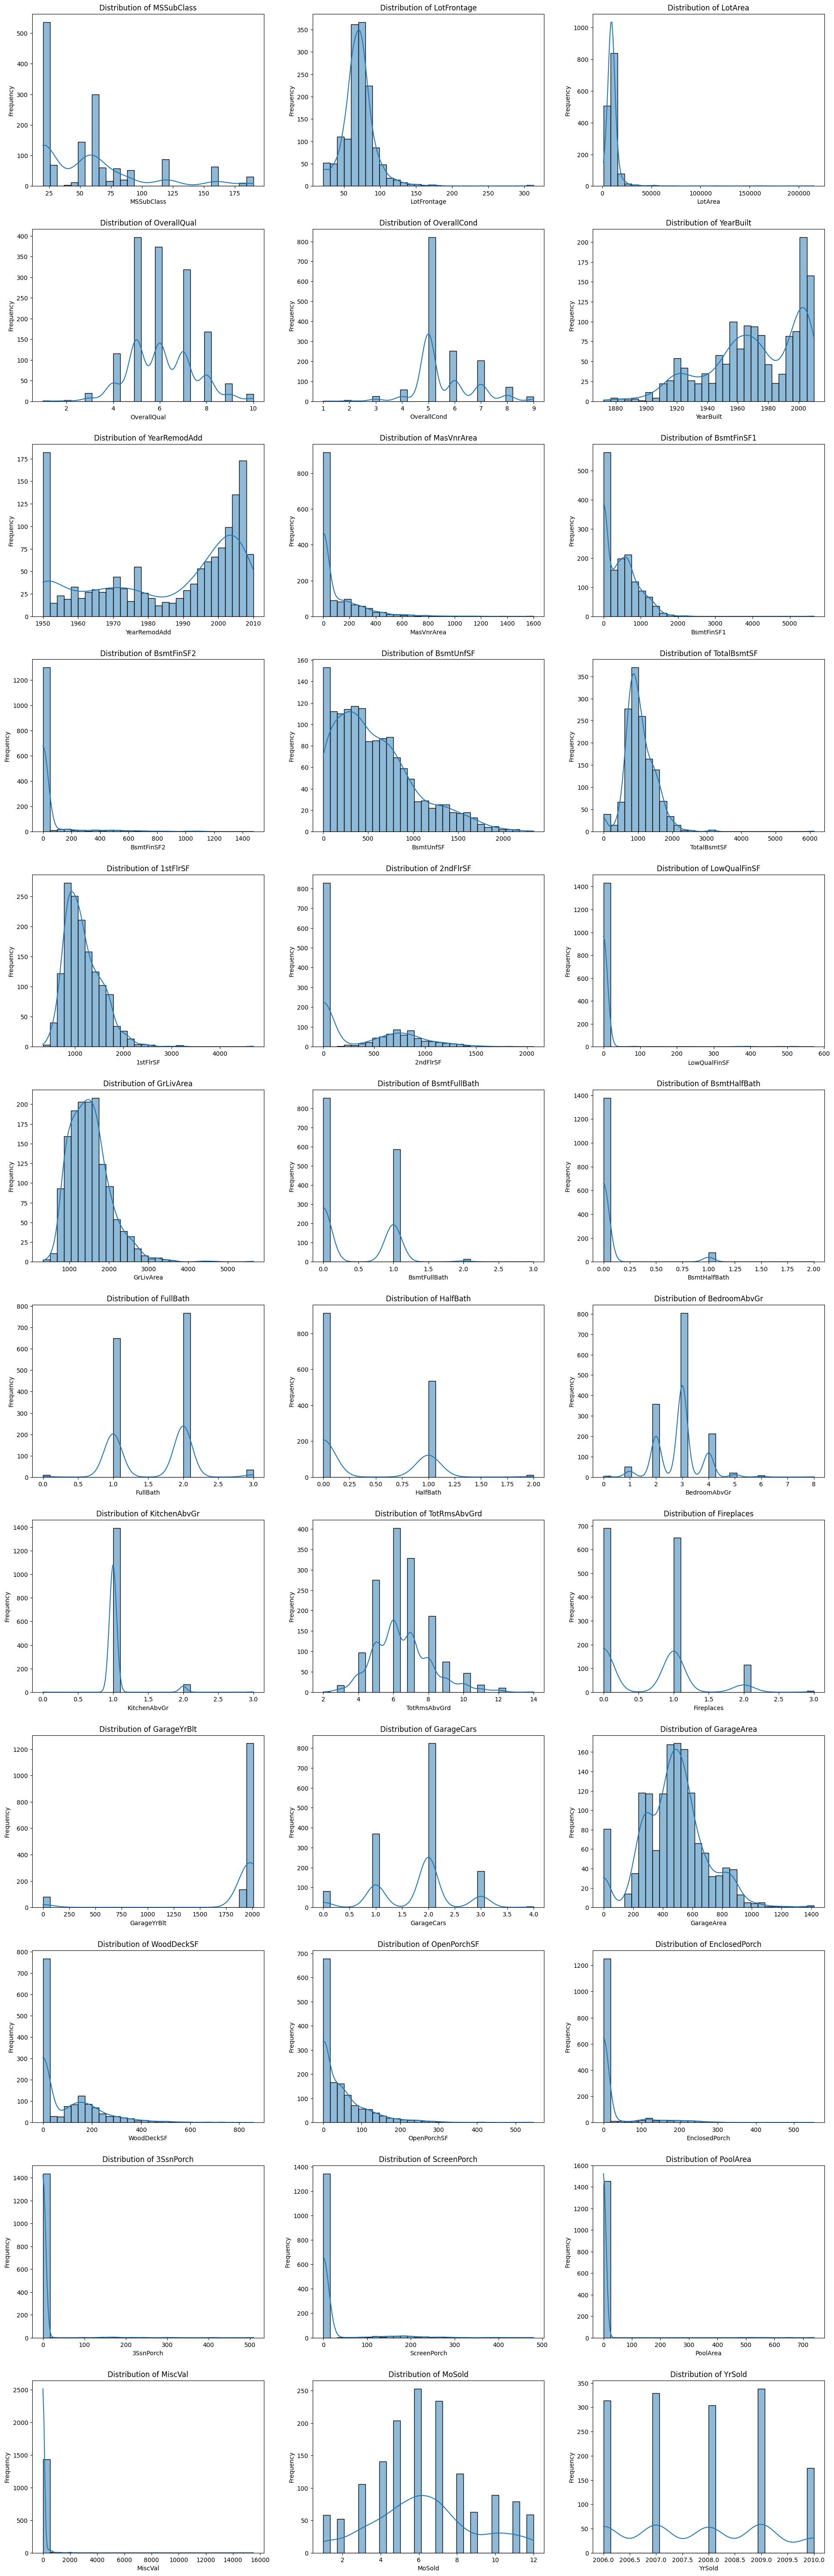

In [21]:
# Numerical Features vs SalePrice

num_cols = 3  # Number of columns in the grid
num_rows = math.ceil(len(numeric_cols) / num_cols)  # Calculate rows based on the number of columns

# Create subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, num_rows * 5))
fig.tight_layout(pad=5.0)  # Adjust spacing between plots

# Loop through numeric columns and plot each one as a histogram
for idx, col in enumerate(numeric_cols):
    row = idx // num_cols
    col_idx = idx % num_cols
    sns.histplot(train_df[col], kde=True, ax=axes[row, col_idx], bins=30)
    axes[row, col_idx].set_title(f'Distribution of {col}')
    axes[row, col_idx].set_xlabel(col)
    axes[row, col_idx].set_ylabel('Frequency')

# Remove any empty subplots
for j in range(len(numeric_cols), num_rows * num_cols):
    fig.delaxes(axes.flatten()[j])

plt.show()

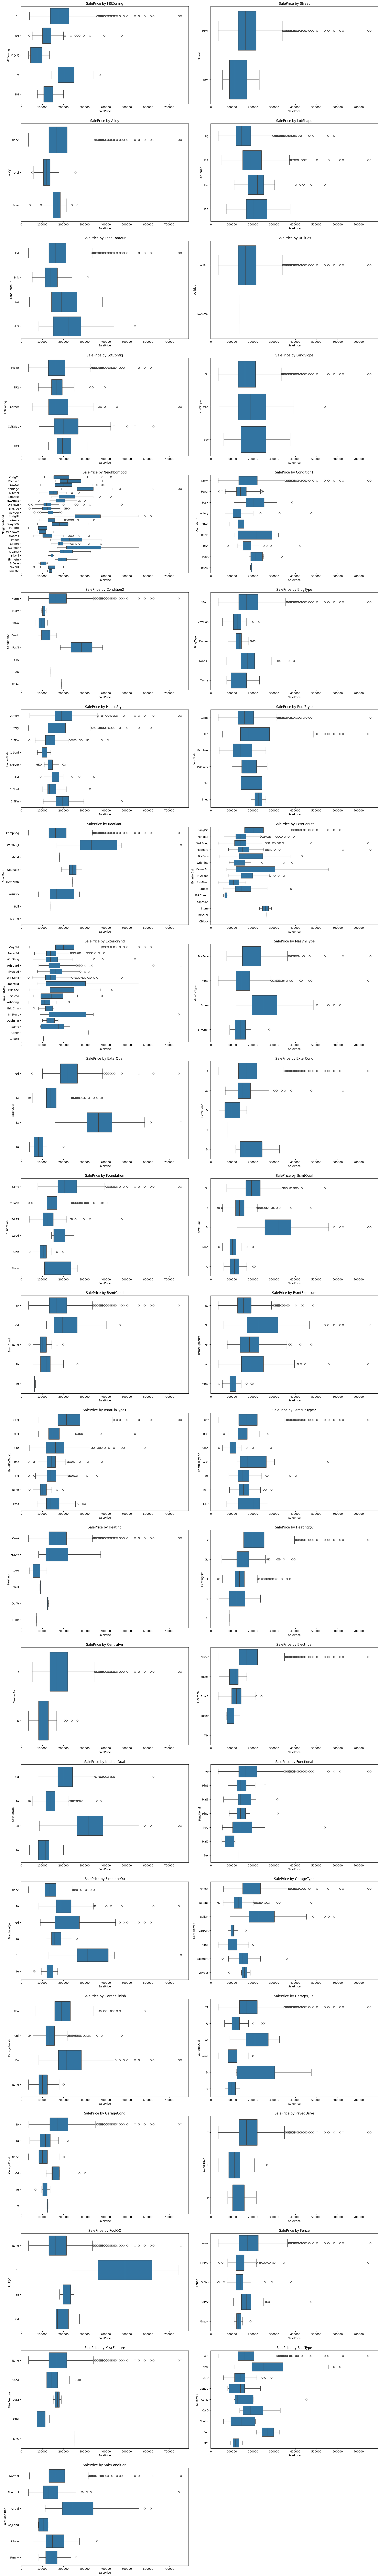

In [22]:
# Categorical Features vs SalePrice

num_cols = 2  # Number of columns in the grid
num_rows = math.ceil(len(categorical_cols) / num_cols)  # Calculate rows based on the number of columns

# Create subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, num_rows * 6))
fig.tight_layout(pad=5.0)  # Adjust spacing between plots

# Loop through categorical columns and plot each one as a box plot
for idx, col in enumerate(categorical_cols):
    row = idx // num_cols
    col_idx = idx % num_cols
    sns.boxplot(y=train_df[col], x=train_df['SalePrice'], ax=axes[row, col_idx])
    axes[row, col_idx].set_title(f'SalePrice by {col}')
    axes[row, col_idx].set_xlabel('SalePrice')
    axes[row, col_idx].set_ylabel(col)

# Remove any empty subplots
for j in range(len(categorical_cols), num_rows * num_cols):
    fig.delaxes(axes.flatten()[j])

plt.show()

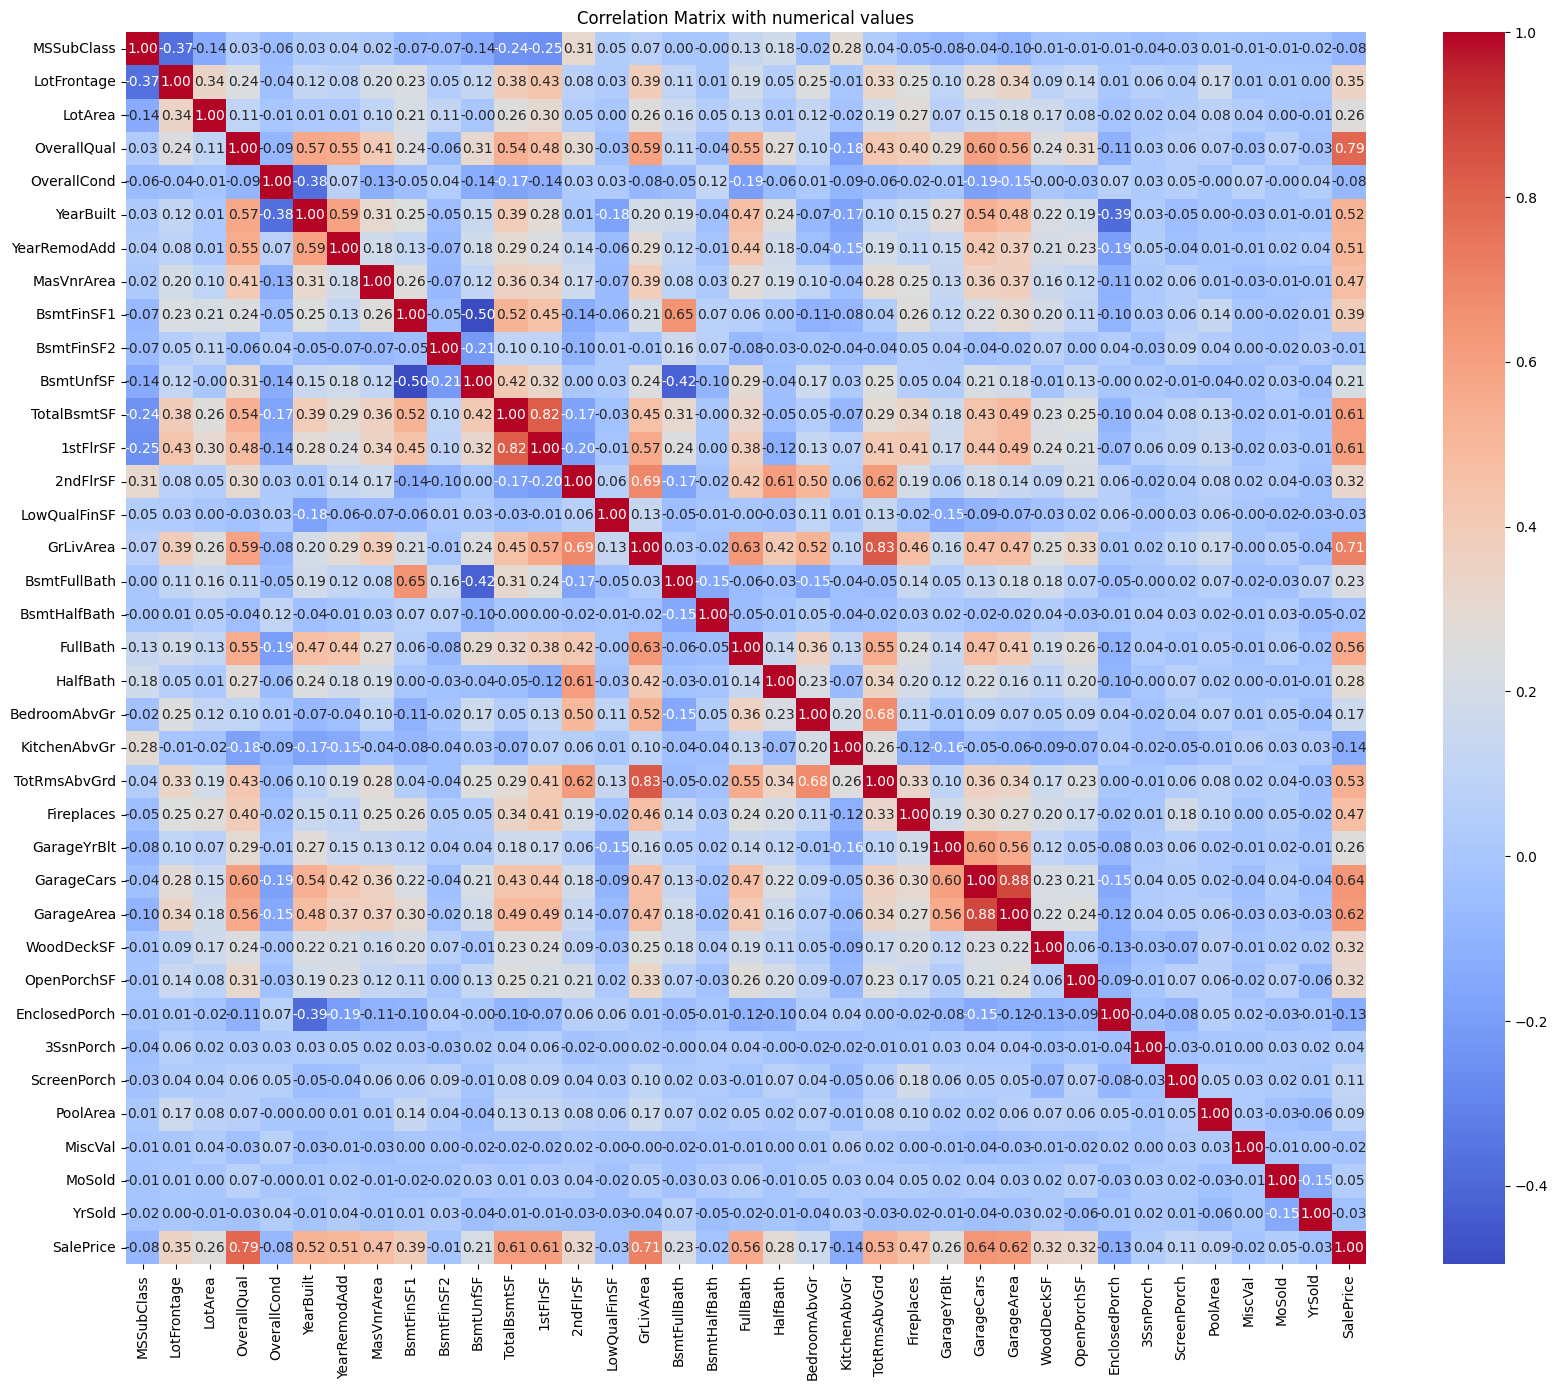

Top 20 features correlated with SalePrice:
SalePrice       1.000000
OverallQual     0.790982
GrLivArea       0.708624
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
FullBath        0.560664
TotRmsAbvGrd    0.533723
YearBuilt       0.522897
YearRemodAdd    0.507101
MasVnrArea      0.473461
Fireplaces      0.466929
BsmtFinSF1      0.386420
LotFrontage     0.349876
WoodDeckSF      0.324413
2ndFlrSF        0.319334
OpenPorchSF     0.315856
HalfBath        0.284108
LotArea         0.263843
GarageYrBlt     0.261366
Name: SalePrice, dtype: float64


In [23]:
correlation = train_df[numeric_cols + ['SalePrice']].corr()
plt.figure(figsize=(20, 16))
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix with numerical values')
plt.show()

# Top 20 features correlated with SalePrice
print("Top 20 features correlated with SalePrice:")
top_corr = correlation['SalePrice'].sort_values(ascending=False).head(21)
print(top_corr)

#### Insights

The top 20 features correlated with SalePrice reveal several key insights into the factors influencing house prices. Notably, OverallQual has the highest correlation (0.79), indicating that the overall quality of the home significantly affects its value; higher-quality finishes and construction materials tend to attract higher prices. Similarly, GrLivArea (0.71) suggests that larger living areas are associated with higher sale prices, emphasizing the importance of space in home valuation.

GarageCars and GarageArea (0.64 and 0.62, respectively) indicate that properties with more garage space and capacity are more desirable, likely reflecting buyer preferences for convenience and functionality. The strong correlation of TotalBsmtSF (0.61) and 1stFlrSF (0.61) highlights the significance of basement and first-floor areas, suggesting that homes with larger usable spaces tend to command higher prices.

The FullBath feature (0.56) further supports the idea that more bathrooms enhance property value, while TotRmsAbvGrd (0.53) implies that homes with more rooms are more appealing to buyers. Features such as YearBuilt (0.52) and YearRemodAdd (0.51) point to the age and modernization of the home as influential factors, with newer or recently renovated homes being more sought after.

Other features like MasVnrArea (0.47) and Fireplaces (0.47) suggest that aesthetic and luxury features can also contribute positively to sale prices. The presence of a fireplace or a significant masonry veneer adds to a home’s charm and appeal.

Lastly, LotFrontage (0.35) and WoodDeckSF (0.32) reflect the importance of outdoor space and landscaping, which can enhance the overall desirability of a property. Understanding these correlations can help in feature selection for predictive modeling, guiding renovations or improvements that could lead to higher property valuations, and informing potential buyers about key attributes to consider when searching for a home.

#### Feature Importance (Not sure with this one yet)

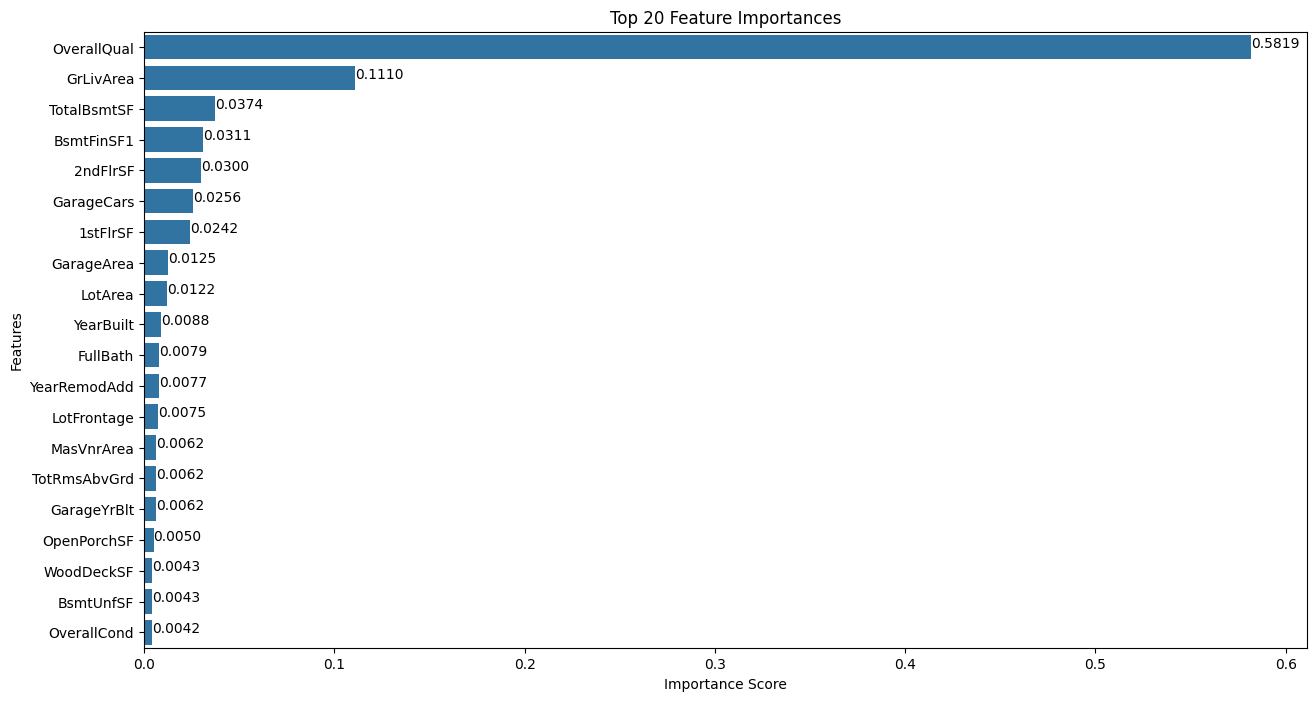

Top 20 features by importance:
OverallQual     0.581864
GrLivArea       0.111046
TotalBsmtSF     0.037386
BsmtFinSF1      0.031054
2ndFlrSF        0.029976
GarageCars      0.025565
1stFlrSF        0.024222
GarageArea      0.012480
LotArea         0.012165
YearBuilt       0.008813
FullBath        0.007941
YearRemodAdd    0.007733
LotFrontage     0.007455
MasVnrArea      0.006224
TotRmsAbvGrd    0.006222
GarageYrBlt     0.006189
OpenPorchSF     0.004982
WoodDeckSF      0.004311
BsmtUnfSF       0.004251
OverallCond     0.004244
dtype: float64


In [25]:
from sklearn.ensemble import RandomForestRegressor

# Prepare data
X = train_df.drop(['SalePrice'], axis=1)
y = train_df['SalePrice']

# Encode categorical variables
X_encoded = pd.get_dummies(X, drop_first=True)

# Fit Random Forest
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_encoded, y)

# Get feature importances
feature_importances = pd.Series(rf.feature_importances_, index=X_encoded.columns)
feature_importances = feature_importances.sort_values(ascending=False)

# Plot top 20 features
plt.figure(figsize=(15, 8))
sns.barplot(x=feature_importances[:20], y=feature_importances.index[:20])
plt.title('Top 20 Feature Importances')
plt.xlabel('Importance Score')
plt.ylabel('Features')

# Annotate bars with the actual importance scores
for index, value in enumerate(feature_importances[:20]):
    plt.text(value, index, f'{value:.4f}')  # Print the value formatted to 4 decimal places

plt.show()

print("Top 20 features by importance:")
print(feature_importances[:20])

## ML Model: SVR

**TODO**
- Light discussion on the models used.
- What biases/assumptions do the algorithms/models have?
- Explain why certain models were used.

In [26]:
import numpy as np
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error as mae 

X = test_df.copy()
y = test_df['SalePrice']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

svr = SVR(kernel='rbf', C=1, epsilon=0.1)
svr.fit(X_train_scaled, y_train)

y_pred = svr.predict(X_test_scaled)

mse = np.mean((y_test - y_pred) ** 2)
print(f"Mean Squared Error: {mse:.2f}")

# Perform hyperparameter tuning for SVR
param_grid_svr = {
    'C': [0.1, 1, 10, 100],
    'epsilon': [0.01, 0.1, 1],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid']
}

grid_search_svr = GridSearchCV(SVR(), param_grid_svr, cv=5, scoring='neg_mean_squared_error')
grid_search_svr.fit(X_train_scaled, y_train)

best_params_svr = grid_search_svr.best_params_
best_score_svr = -grid_search_svr.best_score_

print(f"Best Parameters for SVR: {best_params_svr}")
print(f"Best Mean Squared Error for SVR: {best_score_svr:.2f}")

best_svr = grid_search_svr.best_estimator_
y_pred_best_svr = best_svr.predict(X_test_scaled)

mse_best_svr = mae(y_test, y_pred_best_svr)
print(f"Mean Absolute Error with Best SVR Estimator: {mse_best_svr:.2f}")

Mean Squared Error: 7856469361.13
Best Parameters for SVR: {'C': 100, 'epsilon': 1, 'kernel': 'linear'}
Best Mean Squared Error for SVR: 511164512.60
Mean Absolute Error with Best SVR Estimator: 11774.47


## Results
**TODO**
- Explain why certain metrics were used to evaluate the models.
- Was there anything surprising about the results? Check the scores.
- What is the impact of the preprocessing that you have done on the results of the model?

## Writeup
1. What were the challenges you encountered while implementing it?
2. Any other learnings?